Refer to the Pytorch tutorial for more details: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets
import pandas as pd
import numpy as np
from torch.utils.data.sampler import SubsetRandomSampler

## Device Configuration

In [ ]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device : {device}")

Device : cuda


## Data Prep

create train data and validation set

In [ ]:
from torch.utils.data import DataLoader
from torch.utils.data import random_split
# load and transfor training data from standard source
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) # normalize image to [-1, 1]

train_data = datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

batch_size = 64  # You can adjust this as needed

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=2)
# 10 classes in total
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:13<00:00, 12992216.80it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


## Test Data

In [ ]:
# load test data (note that the data has been transformed already)
test_images = torch.load('./test_image.pt')

## Take a look at your image data

torch.Size([64, 3, 32, 32]) tensor([7, 9, 0, 9, 8, 8, 8, 1, 5, 0, 3, 4, 0, 9, 5, 6, 2, 0, 4, 5, 2, 3, 2, 5,
        9, 8, 2, 4, 9, 5, 5, 3, 4, 1, 9, 9, 2, 8, 0, 3, 1, 0, 5, 2, 7, 0, 6, 3,
        0, 6, 8, 4, 9, 3, 4, 9, 9, 8, 7, 7, 1, 5, 2, 1])


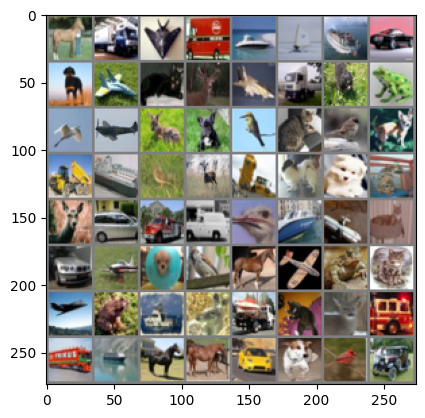

horse truck plane truck ship  ship  ship  car   dog   plane cat   deer  plane truck dog   frog  bird  plane deer  dog   bird  cat   bird  dog   truck ship  bird  deer  truck dog   dog   cat   deer  car   truck truck bird  ship  plane cat   car   plane dog   bird  horse plane frog  cat   plane frog  ship  deer  truck cat   deer  truck truck ship  horse horse car   dog   bird  car  


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.cpu().numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get a random batch of training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

print(images.shape, labels)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

## CNN

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(256 * 4 * 4, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 10)  # 10 classes for CIFAR-10
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

model = CNN()

## Set up optimization method

You tasks:
* Check the Pytorch document about SGD to understand the optimization method
* Tune the optimization hyperparameters

In [ ]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
import random
# Set the random seed
seed = random.randint(1, 10000)
random.seed(seed)
torch.manual_seed(seed)
print(f"Seed = {seed}")

Seed = 3701


In [ ]:
train_losses = []  # Store training losses
model.to(device)
total_epoch = 50
for epoch in range(total_epoch):  # loop over the dataset 'total_epoch' times
    train_loss = 0.0
    valid_loss = 0.0

    # train the model
    model.train()
    for data, target in train_loader: # for each batch of data
        # move data and target to the same device as the model
        data, target = data.to(device), target.to(device)
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item() * data.size(0)

    avg_train_loss = train_loss / len(train_loader.dataset)

    train_losses.append(avg_train_loss)

    # print training/validation statistics
    print(f'Epoch: {epoch+1} / {total_epoch} \tTraining Loss: {avg_train_loss:.6f}')

print('Finished Training')

Epoch: 1 / 50 	Training Loss: 1.637655
Epoch: 2 / 50 	Training Loss: 1.109546
Epoch: 3 / 50 	Training Loss: 0.848802
Epoch: 4 / 50 	Training Loss: 0.680399
Epoch: 5 / 50 	Training Loss: 0.560306
Epoch: 6 / 50 	Training Loss: 0.462011
Epoch: 7 / 50 	Training Loss: 0.371395
Epoch: 8 / 50 	Training Loss: 0.306268
Epoch: 9 / 50 	Training Loss: 0.245134
Epoch: 10 / 50 	Training Loss: 0.204177
Epoch: 11 / 50 	Training Loss: 0.180304
Epoch: 12 / 50 	Training Loss: 0.156299
Epoch: 13 / 50 	Training Loss: 0.148952
Epoch: 14 / 50 	Training Loss: 0.145082
Epoch: 15 / 50 	Training Loss: 0.133584
Epoch: 16 / 50 	Training Loss: 0.125344
Epoch: 17 / 50 	Training Loss: 0.122841
Epoch: 18 / 50 	Training Loss: 0.114997
Epoch: 19 / 50 	Training Loss: 0.108508
Epoch: 20 / 50 	Training Loss: 0.109702
Epoch: 21 / 50 	Training Loss: 0.119243
Epoch: 22 / 50 	Training Loss: 0.105285
Epoch: 23 / 50 	Training Loss: 0.108599
Epoch: 24 / 50 	Training Loss: 0.107394
Epoch: 25 / 50 	Training Loss: 0.102654
Epoch: 26

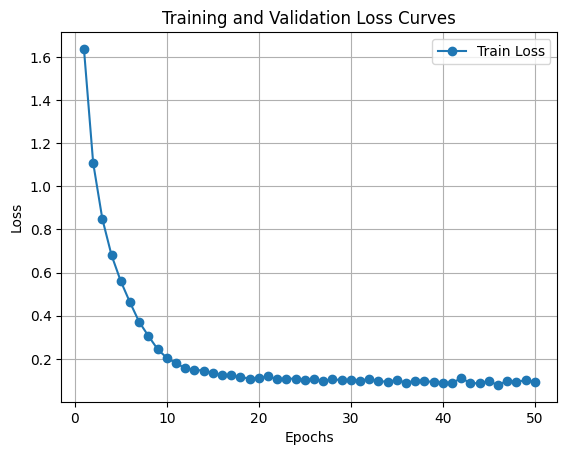

In [ ]:
import matplotlib.pyplot as plt
# Plot the training and validation loss curve
plt.plot(range(1, total_epoch + 1), train_losses, label='Train Loss', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title(f'Training and Validation Loss Curves')
plt.legend()
plt.grid(True)
plt.show()

## Make prediction on test images

['cat' 'dog' 'frog' ... 'plane' 'dog' 'plane']


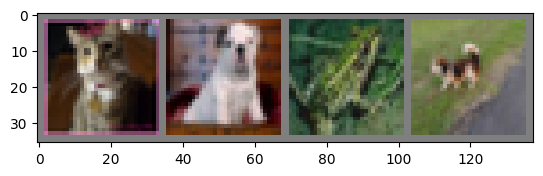

,label
0,cat
1,dog
2,frog
3,dog
4,truck
...,...
4995,deer
4996,ship
4997,plane
4998,dog


In [ ]:
# since now we're testing (not training), we set no_grad to NOT calculate the gradients
with torch.no_grad():
    test_images = test_images.to(device)
    # calculate outputs by running images through the network
    outputs = model(test_images)
    # the class with the highest probability is what we choose as prediction
    _, predicted = torch.max(outputs.data, 1)
    predicted = np.array([classes[i] for i in predicted])

print(predicted)
# show images
imshow(torchvision.utils.make_grid(test_images[:4]))

submission = pd.DataFrame()
submission['label'] = predicted
submission.to_csv("VGG_50.csv", index=True, index_label='id')
submission